# TP naive bayes gausiano
Usamos el dataset fashion MNIST

In [82]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import matplotlib as plt
from matplotlib import pyplot as plot
from scipy import stats
import numpy as np
import numpy.ma as ma
import csv
from scipy.stats import norm
from sklearn.naive_bayes import GaussianNB

label_dict = {
                '0':'T-shirt/top',
                '1':'Trouser',
                '2':'Pullover',
                '3':'Dress',
                '4':'Coat',
                '5':'Sandal',
                '6':'Shirt',
                '7':'Sneaker',
                '8':'Bag',
                '9':'Ankle boot'
            }

## Busco datos 

### Descargo las imagenes

In [11]:
x_data , y_target =fetch_openml('Fashion-MNIST', version=1, return_X_y=True)

### Imprimo una imagen

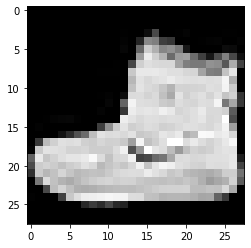

In [12]:
oneImage=x_data[0]
oneImage=oneImage.reshape(28,28)
plot.imshow(oneImage, cmap='gray')
plot.show()

## Imprimo muchas imagenes

In [13]:
#funcion para agrupar imagnes d
def matrixImage(pictures,x,y):
    temp=0
    for i in range(y):
        dataTemp=np.concatenate((pictures[x*i :x*(i+1)]),axis=0)
        if(i==0):
            temp=dataTemp
        else:
            temp=np.concatenate((temp,dataTemp),axis=1)        
    return temp

T-shirt/top


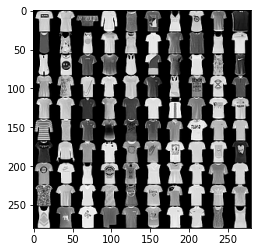

Trouser


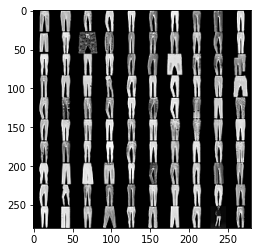

Pullover


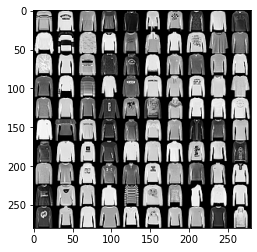

Dress


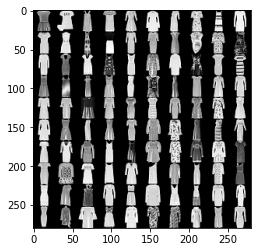

Coat


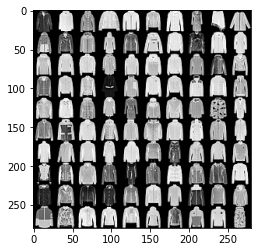

Sandal


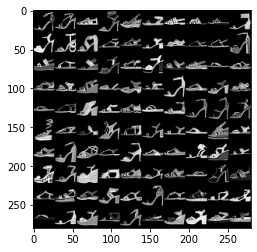

Shirt


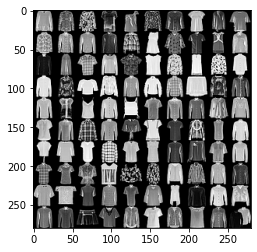

Sneaker


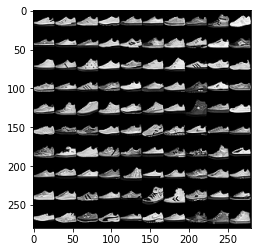

Bag


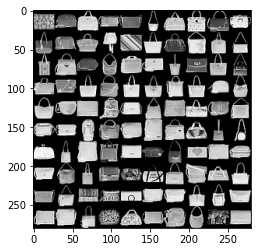

Ankle boot


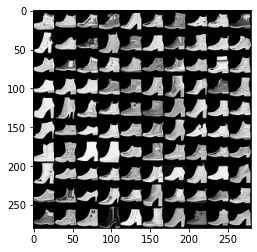

In [14]:


resizeImage=x_data.reshape(70000,28,28)
#j=np.extract(ma.masked_equal(y_target,'2').mask,resizeImage)
for i in range(10):
    print(label_dict[str(i)])
    plot.imshow(matrixImage(resizeImage[ma.masked_equal(y_target,str(i)).mask],10,10), cmap='gray')
    plot.show()
    


## Separo los datos - train valid test

In [15]:
x_train_valid, x_test, y_train_valid, y_test= train_test_split(resizeImage,y_target, test_size=(1.0/7.0), random_state=42,stratify=y_target)
x_train, x_valid, y_train, y_valid = train_test_split(x_train_valid, y_train_valid, test_size=(1.0/6.0), random_state=42,stratify=y_train_valid)

print(len(x_train))
print(len(x_valid))
print(len(x_test))


50000
10000
10000


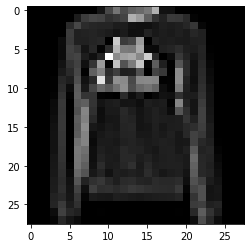

In [16]:
plot.imshow(x_test[10], cmap='gray')
plot.show()

## Calculo las probabilidades

In [17]:
#separo la data por bit


x_train_Columna=np.zeros((28*28,x_train.shape[0]))
for i in range (x_train.shape[0]):
    for j in range(28):
        for u in range(28):
            x_train_Columna[u+28*j][i]=x_train[i][j][u]



#x_trai_Columna[15*15-1][0]
#plot.hist(x_trai_Columna[15*15-1][0][ma.masked_equal(y_train,str(3)).mask],bins=255)

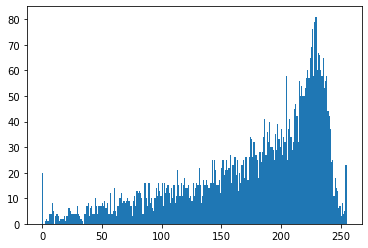

In [18]:
#x_trai_Columna[15+15*28].size
#y_train.size
toHist=x_train_Columna[15+15*28]
toHist=toHist.transpose()
toHist=toHist[ma.masked_equal(y_train,str(3)).mask]
binss=plot.hist(toHist,bins=255)


In [19]:
prioriDress= x_train[ma.masked_equal(y_train,str(3)).mask].shape[0]/x_train.shape[0]
print('Probabilidad a priori de Dress')
print(prioriDress)

Probabilidad a priori de Dress
0.1


In [20]:
print('Frecuencia correpondiente al nivel de gris 147')
print(binss[0][147])
print('Likelihood nivel de gris 147')
print(binss[0][147]/toHist.shape[0])


Frecuencia correpondiente al nivel de gris 147
15.0
Likelihood nivel de gris 147
0.003


Likelihood nivel de gris 147 - 10 bines
0.0842
421.0


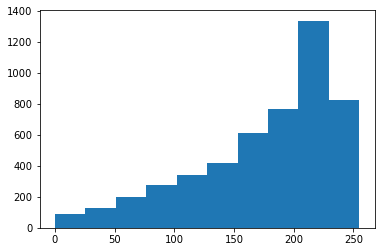

In [21]:
print('Likelihood nivel de gris 147 - 10 bines')
binss10=plot.hist(toHist,bins=10)
print(binss10[0][5]/toHist.shape[0])
print(binss10[0][5])


### Matriz de likelihood

In [22]:
matrizLikeliHood=np.zeros((10,28,28,10)) # [tipos de imagenes][pixel x][pixel y][nivel de gris]
likelihoodBins=[  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,229.5, 255. ]
for i in range(10): #barro las clases
    for j in range(28): #barro pixeles de x
        for u in range(28):#barro pixeles de y
            temp=x_train_Columna[j+u*28]
            #temp=x_train_Columna[1+1*28]
            temp=temp.transpose()
            temp=temp[ma.masked_equal(y_train,str(i)).mask]
            matrizLikeliHood[i][j][u]=np.histogram(temp,bins=likelihoodBins)[0]/temp.shape[0]
            
            #print(np.histogram(temp,bins=[  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,229.5, 255. ])[0])
    #        break
   #     break
  #  break
                 
            


In [23]:
matrizLikeliHood[3][15][15][5]



0.0842

¿Cuál es la probabilidad a posteriori no normalizada de que un pixel con  𝑥𝑔=124  en la posición  [17,17]  pertenezca a la clase "Bag"?

In [24]:
prioriBag= x_train[ma.masked_equal(y_train,str(8)).mask].shape[0]/x_train.shape[0]
print(matrizLikeliHood[8][17][17][4] * prioriBag)

0.00662


## Clasificador NBM y búsqueda de hiperparámetros

In [25]:
def getNewGrayLevels(x,bins):
    
    """ 
    Función que transforme los valores de gris de x 
    para llevarlos a una nueva escala con len(bins) valores de gris, 
    donde cada elemento de bins es un valor de la escala.    
    MODIFICA x!!!!!!!!!!!!!!!!!!!!!!
    """
    for i in range (x.shape[0]):
        for j in range (x.shape[1]):
            for k in range (x.shape[2]):
                x[i][j][k]=bins[np.abs(bins - x[i][j][k]).argmin()]
        
    

In [26]:
x_train_porEscalas=np.array([np.copy(x_train),np.copy(x_train),np.copy(x_train),np.copy(x_train)])
x_val_porEscalas=np.array([np.copy(x_valid),np.copy(x_valid),np.copy(x_valid),np.copy(x_valid)])

binss=[10,64,128,255]
for i in range(3):
    getNewGrayLevels(x_train_porEscalas[i],np.linspace(0,254,binss[i]).astype('uint8'))
    getNewGrayLevels(x_val_porEscalas[i],np.linspace(0,254,binss[i]).astype('uint8'))
    

In [86]:
def getExpandido(x,width,height):
    temp = x.reshape(-1, 28 // height, height, 28 // width, width) 
    #print(temp)
    temp = temp.swapaxes(1, 2).swapaxes(2, 4).swapaxes(3, 4)  
    temp = temp.reshape(-1, 28 // height, 28 // width)
    temp= temp.repeat(height, axis=1).repeat(width, axis=2) 
    return temp.reshape(-1, 28 * 28)


In [28]:

x_extended=getExpandido(x_train_porEscalas[3],2,2)
plot.imshow(x_extended[], cmap='gray')
plot.show()

SyntaxError: invalid syntax (<ipython-input-28-a0cb63befa1d>, line 2)

### Val

In [29]:
alfa={0.1,0.01,0.001,0.0001}
grupo=np.array([[1,1],[2,2],[2,1],[4,4]])
nivelesGriss=4
results=[]
#results.append(['Escala de gris','Alpha','Grupo','Accuraci'])


    


for i in range(nivelesGriss): #barro los ditintos niveles de gris
    
    
    for j in grupo: #barro todos los grupos
        x_expandido=getExpandido(x_train_porEscalas[i],j[0],j[1])
        y_expandido=y_train.repeat(j[0]*j[1])
        
        for a in alfa: #barro los distintos alfa
            clf = MultinomialNB(alpha=a)
            clf.fit(x_expandido, y_expandido)
            score=clf.score(x_val_porEscalas[i].reshape(-1, 28 * 28),y_valid)
            results.append([binss[i],a,j,score])
            
            
        


In [ ]:
"""
# opening the csv file in 'w' mode 
file = open('resultadosNBM.csv', 'w', newline ='') 
  
with file: 
    # identifying header   
    header = ['Escala de gris','Alpha','Grupo','Accuraci'] 
    writer = csv.DictWriter(file, fieldnames = header) 
      
    # writing data row-wise into the csv file 
    writer.writeheader() 
    for x in results:
        writer.writerow({'Escala de gris' : str(x[0]),  
                     'Alpha': str(x[1]),  
                     'Grupo': str(x[2]),
                        'Accuraci':str(x[3])}) 
   
"""

## Naive Bayes Gaussiano

¿Cuál es la media y el desvío estándar del pixel (14,14) en la clase 'Bag' estimados a partir del set de train?

Valor medio
159.3294
Varianza
63.31644095841143


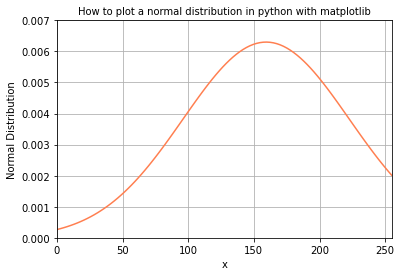

In [31]:
pixelsDeBag=x_train_Columna[14+14*28]
pixelsDeBag=pixelsDeBag.transpose()
pixelsDeBag=pixelsDeBag[ma.masked_equal(y_train,str(8)).mask]
valorMedio1414=np.mean(pixelsDeBag)
desvioStandar1414=np.sqrt(np.var(pixelsDeBag))
print('Valor medio')
print(valorMedio1414)
print('Varianza')
print(desvioStandar1414)




x = np.linspace(np.amin(pixelsDeBag), np.amax(pixelsDeBag), 100)

y = norm.pdf(x,valorMedio1414,desvioStandar1414)

plot.plot(x,y, color='coral')

plot.grid()

plot.xlim(np.amin(pixelsDeBag), np.amax(pixelsDeBag))
plot.ylim(0,0.007)

plot.title('How to plot a normal distribution in python with matplotlib',fontsize=10)

plot.xlabel('x')
plot.ylabel('Normal Distribution')

#plot.savefig("normal_distribution.png")
plot.show()


#plot.hist(pixelsDeBag,bins=255)
#plot(toHist, ,'r-', lw=5, alpha=0.6, label='norm pdf')
#plot.show()

Armar una matriz con la media y el desvío para cada pixel y para cada clase. Tendrá dimensión (2x784x10)

In [36]:
meanStd=np.zeros([10,28*28,2])



valorMedio1414=np.mean(pixelsDeBag)
desvioStandar1414=np.sqrt(np.var(pixelsDeBag))

for i in range(10): #barro las disitntas clases
    for j in range(28): #barro pixeles horizontales
        for u in range(28):
            meanStd[i][j+u*28][0]=np.mean(x_train_Columna[j+u*28].transpose()[ma.masked_equal(y_train,str(i)).mask])
            meanStd[i][j+u*28][1]=np.sqrt(np.var(x_train_Columna[j+u*28].transpose()[ma.masked_equal(y_train,str(i)).mask]))
        
        


In [39]:
meanStd[8][14+14*28][1]

63.31644095841143

### Complejidad del modelo

¿Cuántos parámetros tendrá el modelo de Naive Bayes Gaussiano dado que se asumió independencia entre los píxeles?

medias = 784

varinazas = 784

parametrosTotales=medias+varianzas=1568

Si no se asume independencia, es decir que las covarianzas entre variables no se desprecian: ¿cuántos parámetros tendría el modelo?

medias = 784

varinazas = $ \frac{784 \cdot 784}{2} + 784 =308712$ La matriz de covariancias es simetrica

parametrosTotales=medias+varianzas=308896



## Naive Bayes Gaussiano como clasificador

In [87]:
alfa={1,0.1,0.001,0.00001,0.0000001}
grupo=np.array([[1,1],[2,2],[2,1],[4,4]])
nivelesGriss=4
results=[]
#results.append(['Escala de gris','Alpha','Grupo','Accuraci'])


    


for i in range(nivelesGriss): #barro los ditintos niveles de gris
    
    
    for j in grupo: #barro todos los grupos
        x_expandido=getExpandido(x_train_porEscalas[i],j[0],j[1])
        y_expandido=y_train.repeat(j[0]*j[1])
        
        for a in alfa: #barro los distintos alfa
            clf = GaussianNB(var_smoothing=a)
            clf.fit(x_expandido, y_expandido)
            score=clf.score(x_val_porEscalas[i].reshape(-1, 28 * 28),y_valid)
            results.append([binss[i],a,j,score])
            
            
        

In [89]:
""""
# opening the csv file in 'w' mode 
file = open('resultadosNBG.csv', 'w', newline ='') 
  
with file: 
    # identifying header   
    header = ['Escala de gris','Alpha','Grupo','Accuraci'] 
    writer = csv.DictWriter(file, fieldnames = header) 
      
    # writing data row-wise into the csv file 
    writer.writeheader() 
    for x in results:
        writer.writerow({'Escala de gris' : str(x[0]),  
                     'Alpha': str(x[1]),  
                     'Grupo': str(x[2]),
                        'Accuraci':str(x[3])}) 
   
""""

Mejor resultado

Escala de gris	Alpha	Grupo	Accuraci

128	             0.1	[1 1]	0.6718
